<a href="https://colab.research.google.com/github/nagarad/OCR/blob/main/Face_Detection_%26_Name_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## 1. Face recognition 

In [ ]:
path = "/content/drive/MyDrive/Face Detection & Name Recognition/Tensorflow face images"

X = []
for p in glob(f'{path}/*.jpg'):
  X.append(plt.imread(p))

In [ ]:
X = np.array(X)
print('Shape of X : ', X.shape)

Shape of X :  (14, 218, 178, 3)


In [ ]:
df = pd.read_csv('/content/bounding_box.csv', index_col = 0)

In [ ]:
df.shape

(14, 4)

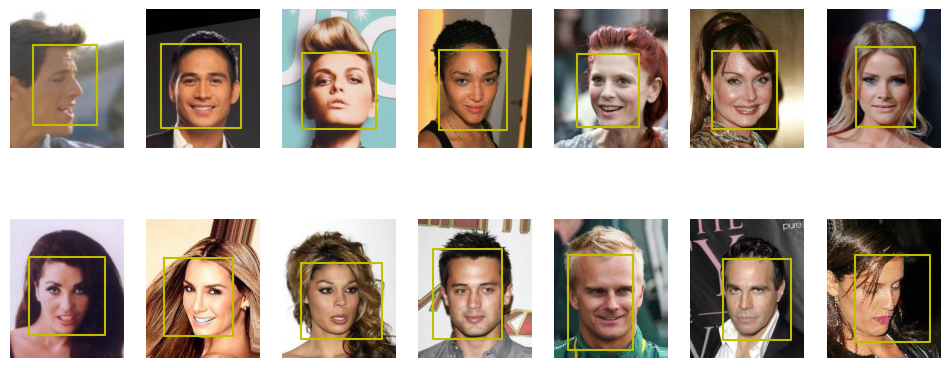

In [ ]:
plt.figure(figsize=(12,5))
j=1
for i in range(0, 14):
    plt.subplot(2,7,j)
    plt.axis('off')
    img = X[i]
    plt.imshow(img, cmap = 'gray')
    x_min = df.xmin[i]
    x_max = df.xmax[i]
    y_min = df.ymin[i]
    y_max = df.ymax[i]
    plt.plot([x_min, x_min, x_max, x_max, x_min], [y_min, y_max, y_max, y_min, y_min], '-y')
    j+=1

In [ ]:
df['x_mean'] = (df['xmax'] + df['xmin'])/2
df['y_mean'] = (df['ymax'] + df['ymin'])/2
df['h'] = df['ymax'] - df['ymin']
df['w'] = df['xmax'] - df['xmin']

df.drop(columns = ['xmin', 'ymin', 'xmax', 'ymax'], inplace = True)

In [ ]:
X.shape

(14, 218, 178, 3)

In [ ]:
df = df/256
df

,x_mean,y_mean,h,w
0,0.335938,0.462891,0.488281,0.390625
1,0.335938,0.468750,0.515625,0.492188
2,0.347656,0.501953,0.464844,0.453125
3,0.332031,0.492188,0.492188,0.414062
4,0.328125,0.498047,0.449219,0.382812
5,0.328125,0.496094,0.476562,0.398438
6,0.357422,0.476562,0.492188,0.363281
7,0.347656,0.470703,0.480469,0.460938
8,0.318359,0.474609,0.480469,0.425781
9,0.361328,0.501953,0.464844,0.496094


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, df, test_size = 0.2, random_state= 7)

In [ ]:
y_test

,x_mean,y_mean,h,w
12,0.404297,0.490234,0.496094,0.417969
11,0.281250,0.509766,0.582031,0.398438
2,0.347656,0.501953,0.464844,0.453125


In [ ]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224,224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(1024, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4))  # 4 outputs for bounding box coordinates (xmin, ymin, xmax, ymax)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 512)       1180160   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 512)     

In [ ]:
def cc_coef(y_true, y_pred):
    x_mean_true, y_mean_true, h_true, w_true = tf.unstack(y_true, axis=-1)
    x_mean_pred, y_mean_pred, h_pred, w_pred = tf.unstack(y_pred, axis=-1)

    epsilon = 1e-8

    mu_y = tf.square(y_mean_true - y_mean_pred)
    mu_x = tf.square(x_mean_true - x_mean_pred)
    mu_h = tf.square(tf.sqrt(tf.abs(w_true) + epsilon) - tf.sqrt(tf.abs(w_pred) + epsilon))
    mu_w = tf.square(tf.sqrt(tf.abs(h_true) + epsilon) - tf.sqrt(tf.abs(h_pred) + epsilon))

    return tf.reduce_mean(mu_y + mu_x + mu_h + mu_w)

In [ ]:
model.compile(optimizer='adam', loss= cc_coef, metrics = 'accuracy')

In [ ]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 350.3936 - accuracy: 0.0000e+00 - val_loss: 15343915.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 139ms/step - loss: 13400269.0000 - accuracy: 0.1818 - val_loss: 16948.6699 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 137ms/step - loss: 14856.5625 - accuracy: 0.0000e+00 - val_loss: 164.8172 - val_accuracy: 0.6667
Epoch 4/50
1/1 [==============================] - 0s 138ms/step - loss: 143.4566 - accuracy: 0.5455 - val_loss: 6613.7124 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 152ms/step - loss: 6086.1558 - accuracy: 0.1818 - val_loss: 34.7333 - val_accuracy: 0.6667
Epoch 6/50
1/1 [==============================] - 0s 145ms/step - loss: 31.0164 - accuracy: 0.5455 - val_loss: 376.9750 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 136ms/step - loss: 344.3103 - accuracy: 0.0000e+

In [ ]:
pred = model.predict(x_test)

1/1 [==============================] - 0s 84ms/step


In [ ]:
pred

array([[ 0.78919137,  0.453083  ,  1.1639254 , -0.7716776 ],
       [ 1.0551425 ,  0.60808927,  1.5661608 , -1.0267634 ],
       [ 1.1099209 ,  0.64001614,  1.6490097 , -1.0793037 ]],
      dtype=float32)

In [ ]:
x_p, y_p, h_p, w_p = pred[0]*256

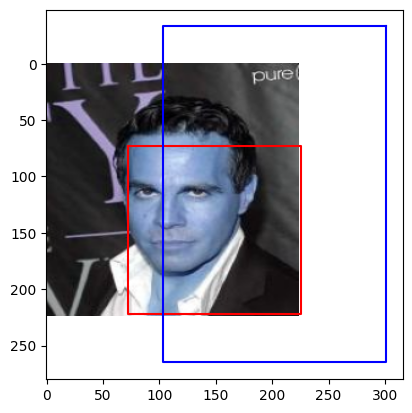

In [ ]:
x1_p = x_p - 0.5 * w_p
y1_p = y_p - 0.5 * h_p
x2_p = x_p + 0.5 * w_p
y2_p = y_p + 0.5 * h_p


x1_t = 256 * y_test.loc[12, 'x_mean'] - 0.5 * 256 * y_test.loc[12, 'w']
y1_t = 256 * y_test.loc[12, 'y_mean'] - 0.5 * 256 * y_test.loc[12, 'h']
x2_t = 256 * y_test.loc[12, 'x_mean'] + 0.5 * 256 * y_test.loc[12, 'w']
y2_t = 256 * y_test.loc[12, 'y_mean'] + 0.5 * 256 * y_test.loc[12, 'h']


plt.imshow(x_test[0])
plt.plot([x1_t, x1_t, x2_t, x2_t, x1_t], [y1_t, y2_t, y2_t, y1_t, y1_t], '-r')
plt.plot([x1_p, x1_p, x2_p, x2_p, x1_p], [y1_p, y2_p, y2_p, y1_p, y1_p], '-b')

In [ ]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
model = json_file.read()

# Load model
model = model_from_json(model)

# Load weights
model.load_weights('./weights/face_detection')

### Intersection over Union (optional part)


In [ ]:
def cal_iou(y_true, y_pred):
    x1 = max(y_true[0], y_pred[0])
    y1 = max(y_true[1], y_pred[1])
    x2 = min(y_true[2], y_pred[2])
    y2 = min(y_true[3], y_pred[3])
 
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
 
    true_area = (y_true[2] - y_true[0] + 1) * (y_true[3] - y_true[1] + 1)
    bbox_area = (y_pred[2] - y_pred[0] + 1) * (y_pred[3] - y_pred[1] + 1)
 
    iou = intersection_area / float(true_area + bbox_area - intersection_area)
    return iou

## 2. Name recognition

In [ ]:
ner_dataset = pd.read_csv('/content/ner_dataset.csv',delimiter=';', encoding = 'latin1')

In [ ]:
ner_dataset = ner_dataset.fillna(method="ffill")
ner_dataset.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
ner_dataset = ner_dataset.drop(['POS'], axis=1)
ner_dataset = ner_dataset.groupby('Sentence #').agg(list)
ner_dataset = ner_dataset.reset_index(drop=True)
ner_dataset.head()

,Word,Tag
0,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,"[The, step, will, allow, the, facility, to, op...","[O, O, O, O, O, O, O, O, O, O, O, O]"
3,"[The, European, Union, with, U.S., backing, ha...","[O, B-org, I-org, O, B-gpe, O, O, O, O, O, B-g..."
4,"[Iran, 's, new, President, Mahmoud, Ahmadineja...","[B-gpe, O, O, B-per, I-per, I-per, O, B-tim, O..."


In [ ]:
for index, row in ner_dataset.iterrows():
    word = row['Word']
    tag = row['Tag']
    print(f'Word: {word}, Tag: {tag}')

Word: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'], Tag: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
Word: ['Iranian', 'officials', 'say', 'they', 'expect', 'to', 'get', 'access', 'to', 'sealed', 'sensitive', 'parts', 'of', 'the', 'plant', 'Wednesday', 'after', 'an', 'IAEA', 'surveillance', 'system', 'begins', 'functioning', '.'], Tag: ['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O']
Word: ['The', 'step', 'will', 'allow', 'the', 'facility', 'to', 'operate', 'at', 'full', 'capacity', '.'], Tag: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Word: ['The', 'European', 'Union', 'with', 'U.S.', 'backing', 'has', 'threatened', 'to', 'ref

In [ ]:
word_to_index = {}
tag_to_index = {}

# Iterating over the dataset
for _, row in ner_dataset.iterrows():
    words = row['Word']
    tags = row['Tag']

    # Adding words to the word-to-index dictionary
    for word in words:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

    # Adding tags to the tag-to-index dictionary
    for tag in tags:
        if tag not in tag_to_index:
            tag_to_index[tag] = len(tag_to_index)

# Displaying the word-to-index dictionary
print("Word-to-index dictionary:")
for word, index in word_to_index.items():
    print(f'Word: {word}, Index: {index}')

# Displaying the tag-to-index dictionary
print("\nTag-to-index dictionary:")
for tag, index in tag_to_index.items():
    print(f'Tag: {tag}, Index: {index}')

Word-to-index dictionary:
Word: Thousands, Index: 0
Word: of, Index: 1
Word: demonstrators, Index: 2
Word: have, Index: 3
Word: marched, Index: 4
Word: through, Index: 5
Word: London, Index: 6
Word: to, Index: 7
Word: protest, Index: 8
Word: the, Index: 9
Word: war, Index: 10
Word: in, Index: 11
Word: Iraq, Index: 12
Word: and, Index: 13
Word: demand, Index: 14
Word: withdrawal, Index: 15
Word: British, Index: 16
Word: troops, Index: 17
Word: from, Index: 18
Word: that, Index: 19
Word: country, Index: 20
Word: ., Index: 21
Word: Iranian, Index: 22
Word: officials, Index: 23
Word: say, Index: 24
Word: they, Index: 25
Word: expect, Index: 26
Word: get, Index: 27
Word: access, Index: 28
Word: sealed, Index: 29
Word: sensitive, Index: 30
Word: parts, Index: 31
Word: plant, Index: 32
Word: Wednesday, Index: 33
Word: after, Index: 34
Word: an, Index: 35
Word: IAEA, Index: 36
Word: surveillance, Index: 37
Word: system, Index: 38
Word: begins, Index: 39
Word: functioning, Index: 40
Word: The, 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Convert words and tags to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts([word for sentence in ner_dataset['Word'] for word in sentence])
sequences = tokenizer.texts_to_sequences([word for sentence in ner_dataset['Word'] for word in sentence])

# Determine the maximum sequence length
max_sequence_length = max(len(seq) for seq in sequences)

# Pad sequences to a fixed length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Determine the vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1

In [ ]:
embedding_dim = 100

In [ ]:
# Split the data into training and testing sets
X = padded_sequences
y = [tag for sentence in ner_dataset['Tag'] for tag in sentence]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Determine the number of classes and perform label encoding
num_classes = len(set(y))
tag_to_index = {tag: i for i, tag in enumerate(set(y))}
y_train_encoded = [tag_to_index[tag] for tag in y_train]
y_test_encoded = [tag_to_index[tag] for tag in y_test]

# Perform one-hot encoding
y_train_encoded = to_categorical(y_train_encoded, num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, BatchNormalization

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(BatchNormalization())
model.add(LSTM(units=64))
model.add(Dense(units=num_classes, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2, 100)            27600     
                                                                 
 batch_normalization (BatchN  (None, 2, 100)           400       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 11)                715       
                                                                 
Total params: 70,955
Trainable params: 70,755
Non-trainable params: 200
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, validation_data = (X_test, y_test_encoded), epochs=10, batch_size=32)

Epoch 1/10
12/12 [==============================] - 5s 181ms/step - loss: 0.0578 - accuracy: 0.9592 - val_loss: 0.7782 - val_accuracy: 0.8261
Epoch 2/10
12/12 [==============================] - 1s 95ms/step - loss: 0.0484 - accuracy: 0.9728 - val_loss: 0.7287 - val_accuracy: 0.8261
Epoch 3/10
12/12 [==============================] - 0s 13ms/step - loss: 0.0472 - accuracy: 0.9755 - val_loss: 0.6841 - val_accuracy: 0.8261
Epoch 4/10
12/12 [==============================] - 0s 36ms/step - loss: 0.0414 - accuracy: 0.9755 - val_loss: 0.6566 - val_accuracy: 0.8261
Epoch 5/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0438 - accuracy: 0.9701 - val_loss: 0.6344 - val_accuracy: 0.8261
Epoch 6/10
12/12 [==============================] - 0s 10ms/step - loss: 0.0399 - accuracy: 0.9755 - val_loss: 0.6002 - val_accuracy: 0.8261
Epoch 7/10
12/12 [==============================] - 0s 8ms/step - loss: 0.0427 - accuracy: 0.9701 - val_loss: 0.5684 - val_accuracy: 0.8370
Epoch 8/10
12/

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded, batch_size=32)

# Make predictions
predictions = model.predict(X_test)

3/3 [==============================] - 0s 5ms/step
